# Workshop 1: Introduction to `PyPSA` & TYNDP reference grids

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `linopy`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa matplotlib cartopy highspy
```
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
|  | **not used in this course** |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components.

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

# Using the PyPSA framework: a simple example

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket 🚀 in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews
%env HV_DOC_HTML=true
```
:::

In [ ]:
# For executing this notebook in Google Colab
#!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews
# %env HV_DOC_HTML=true

# Depedencies

In [ ]:
# By convention, PyPSA is imported without an alias:
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import holoviews as hv
import cartopy.crs as ccrs
from pypsa.plot.maps.static import (
    add_legend_circles,
    add_legend_patches,
    add_legend_lines,
)
from pathlib import Path

plt.style.use("bmh")

### Simple electricity market problem
Copyright (c) 2025, Iegor Riepin

generator 1: "gas" -- marginal cost 70 EUR/MWh -- capacity 50 MW

generator 2: "nuclear" -- marginal cost 10 EUR/MWh -- capacity 100 MW

load: "Consumer" -- demand 120 MW

single time step ("now")

single node ("Springfield")

### Building a basic network

In [ ]:
# First, we create a network object which serves as the container for all components
n = pypsa.Network()

In [ ]:
n

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [ ]:
n.add("Bus", "Springfield", v_nom=380, carrier="AC")

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [ ]:
n.buses

You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components.

The `n.add()` function lets you add any component to the network object `n`:

In [ ]:
n.add(
    "Generator",
    "gas",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "nuclear",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=10,  # €/MWh
    p_nom=100,  # MW
)

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

As a result, the `n.generators` DataFrame looks like this:

In [ ]:
n.generators

Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [ ]:
n.add(
    "Load",
    "Small town",
    bus="Springfield",
    p_set=120,  # MW
)

In [ ]:
n.loads

## Optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For this dispatch problem, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{s,t};} \sum_{t,s} o_{s} g_{s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{s,t} \leq G_{s}  & \text{generation limits : generator} \\
D_t &= \sum_s g_{s,t} & \text{market clearing : bus} \\
\end{align}

**Decision variables:**

- $g_{s,t}$ is the generator dispatch of technology $s$ at time $t$

**Parameters:**

- $o_{s}$ is the marginal generation cost of technology $s$
- $G_{s}$ is the nominal capacity of technology $s$
- $D_t$ is the power demand in Springfiled at time $t$


With all input data transferred into the PyPSA's data structure (`network`), we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost adhering to the constraints defined in the network.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [ ]:
n.optimize(solver_name="highs")

Let's have a look at the results. The network object `n` contains now the objective value and the results for the decision variables.

In [ ]:
n.objective

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different locations than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [ ]:
n.generators_t.p

In [ ]:
n.buses_t.marginal_price

In [ ]:
n.generators_t.mu_upper

### Explore pypsa model

In [ ]:
n.model

In [ ]:
n.model.constraints

In [ ]:
n.model.constraints["Generator-fix-p-upper"]

In [ ]:
n.model.constraints["Bus-nodal_balance"]

In [ ]:
n.model.objective

# Hands-on Session 1: Building the reference grids

## Load Example Data

In [ ]:
from urllib.request import urlretrieve

urls = {
    "pre-network.nc": "https://drive.google.com/uc?export=download&id=1KizODRyW0UVLKzIY5MZlDZi52zN0tSZc",
    "post-network.nc": "https://drive.google.com/uc?export=download&id=1O9bkv7382rAhnY493aa9SLaXl4AdVfSw",
    "bidding_zones.geojson": "https://drive.google.com/uc?export=download&id=1ZjcNdSiE9OTUetcV1MBV8qn6KIKMYQkM",
}
for name, url in urls.items():
    print(name)
    urlretrieve(url, name)

First, let's load a pre-composed PyPSA Network:

In [ ]:
n = pypsa.Network("pre-network.nc")

And let's get a general overview of the components in it:

In [ ]:
n.component

We have buses which represent the different nodes in the model where components attach.

In [ ]:
n.buses

And let's zoom on a specific country.

In [ ]:
n.buses.query("country=='IT' and carrier=='AC'")

We can also explore the network spatially.

In [ ]:
n.explore()

Generators which represent generating units (e.g. power plant, wind turbine, PV panel):

In [ ]:
n.generators

Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul>

In [ ]:
n.links

In [ ]:
n.links.query("carrier.str.contains('H2') and Link.str.contains('DE')").sort_values(
    by=["carrier", "bus0", "bus1"]
)

In [ ]:
n.links.query("carrier == 'DC'")

In [ ]:
n.links.query("carrier == 'DC' and Link.str.contains('DE')").sort_index()

In [ ]:
n.loads

In [ ]:
n.loads_t.p_set.loc[:, n.loads.query("carrier == 'electricity'").index].sum(axis=1).div(
    1e3
).plot(ylabel="GW")

## Explore Bidding Zones

To begin this section, let's start by examining the spatial resolution of the electricity grid representation 
in the Scenario Building Exercise which is the Bidding Zones.

Let's load the Bidding Zone shapes that we created for the PyPSA model:

In [ ]:
bz = gpd.read_file("bidding_zones.geojson")

Let's have a look at the file:

In [ ]:
bz.head()

Let's use a nice interactive plotting package to plot the regions.

`.hvplot()` is a powerful and interactive Pandas-like `.plot()` API. You just replace `.plot()` with `.hvplot()` and you get an interactive figure.

Documentation can be found here: https://hvplot.holoviz.org/index.html

In [ ]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)

In [ ]:
# set the projection to specify for all geoplotting in this notebook
proj = load_projection(dict(name="EqualEarth"))

In [ ]:
hv.extension("bokeh")
bz.hvplot(
    geo=True,
    tiles="OSM",
    hover_cols=["zone_name", "country"],
    c="zone_name",
    frame_height=700,
    frame_width=1000,
    alpha=0.2,
    legend=False,
).opts(xaxis=None, yaxis=None, active_tools=["pan", "wheel_zoom"])

## Explore the Electricity reference grid

The Electricity reference grid in the `PyPSA` model was implemented as HVAC lines that neglect KVL and only net transfer capacities (NTCs).

This is referred to as a `Transport Model`.

In `PyPSA`, this can be represented by the `link` component with carrier set to 'DC'.

Let's have a look at those links:

In [ ]:
reference_grid_elec = n.links.query("carrier == 'DC'")
(
    reference_grid_elec.loc[
        :, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]
    ].head(10)
)

Or we can compute the total transmission capacity of the system in `TWkm`:

In [ ]:
total_TWkm = (
    reference_grid_elec.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_elec.length)
    .sum()
    .round(2)
)
print(
    f"Total electricity reference grid has a transmission capacity of {total_TWkm} TWkm."
)

We can also check some individual number for specific connections using the `query()` or the `filter(like='<your-filter>')` method.

In [ ]:
# example
# `query()`
print(reference_grid_elec.query("Link.str.contains('DE00-BE00')").p_nom)  # in MW
# or `filter()`
print(reference_grid_elec.filter(like="DE00-BE00", axis=0).p_nom)

In [ ]:
# Task: extract and filter for specific capacity information from your home country and compare with your data about these connections

Additionally, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the electricity reference grid:

In [ ]:
# explore the reference grid
n_elec_grid = n.copy()
n_elec_grid.remove(
    "Bus", n_elec_grid.buses.query("carrier != 'AC' or Bus.str.contains('DRES')").index
)
n_elec_grid.explore()

We can also plot the electricity grid by utilizing a handy plotting function:

In [ ]:
def plot_electricity_reference_grid(n, regions, proj):
    lw_factor = 1e3 if n.lines.empty else 2e3

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": proj})
    regions.to_crs(proj.proj4_init).plot(
        ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.75
    )
    n.plot.map(
        ax=ax,
        margin=0.06,
        line_widths=n.lines.s_nom / lw_factor,
        link_widths=n.links.p_nom / lw_factor,
    )

    if not n.lines.empty:
        sizes_ac = [10, 20]
        labels_ac = [f"HVAC ({s} GW)" for s in sizes_ac]
        scale_ac = 1e3 / lw_factor
        sizes_ac = [s * scale_ac for s in sizes_ac]

        legend_kw_ac = dict(
            loc=[0.25, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_ac,
            labels_ac,
            patch_kw=dict(color="rosybrown"),
            legend_kw=legend_kw_ac,
        )

    if not n.links.empty:
        sizes_dc = [1, 5]
        labels_dc = [f"HVDC ({s} GW)" for s in sizes_dc]
        scale_dc = 1e3 / lw_factor
        sizes_dc = [s * scale_dc for s in sizes_dc]

        legend_kw_dc = dict(
            loc=[0.0, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_dc,
            labels_dc,
            patch_kw=dict(color="darkseagreen"),
            legend_kw=legend_kw_dc,
        )

    plt.show()

In [ ]:
plot_electricity_reference_grid(n_elec_grid, bz, proj)

## Explore the Hydrogen reference grid

Similar to the Electricity reference grid, the H2 reference grid in the `PyPSA` model was implemented using the `link` component to represent the transport model of the Scenario Building exercise.

Let's have a look at those Hydrogen reference grid links:

In [ ]:
reference_grid_h2 = n.links.query("carrier == 'H2 pipeline'")
(
    reference_grid_h2.loc[:, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]].head(
        10
    )
)

Again, we can compute the total transmission capacity of the system in `TWkm`:

In [ ]:
total_TWkm = (
    reference_grid_h2.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_h2.length)
    .sum()
    .round(2)
)
print(f"The H2 reference grid has a total transmission capacity of {total_TWkm} TWkm.")

And also extract and check some individual numbers for specific connections:

In [ ]:
# Task: extract and filter for specific capacity information and compare with your data about these connections

Again, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the hydrogen reference grid. 

As we can see, the spatial resolution of the H2 reference grid is different to the electricity reference grid.

In [ ]:
# explore the reference grid
n_h2_grid = n.copy()
n_h2_grid.remove("Bus", n_h2_grid.buses.query("carrier != 'H2'").index)
n_h2_grid.remove("Link", n_h2_grid.links.query("p_nom == 0").index)
n_h2_grid.explore()

We can also plot the electricity grid by importing and utilizing a handy plotting function:

In [ ]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


def plot_h2_reference_grid(network, map_opts):
    n = network.copy()

    linewidth_factor = 4e3

    n.links.drop(
        n.links.index[~n.links.carrier.str.contains("H2 pipeline")], inplace=True
    )
    h2_pipes = n.links[n.links.carrier == "H2 pipeline"].p_nom
    link_widths_total = h2_pipes / linewidth_factor
    if link_widths_total.notnull().empty:
        print("No base H2 pipeline capacities to plot.")
        return
    link_widths_total = link_widths_total.reindex(n.links.index).fillna(0.0)

    proj = load_projection(dict(name="EqualEarth"))
    n.buses.drop(n.buses.index[~n.buses.carrier.str.contains("H2")], inplace=True)

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": proj})
    color_h2_pipe = "#499a9c"
    color_h2_node = "#ff29d9"

    n.plot.map(
        geomap=True,
        bus_sizes=0.1,
        bus_colors=color_h2_node,
        link_colors=color_h2_pipe,
        link_widths=link_widths_total,
        branch_components=["Link"],
        ax=ax,
        **map_opts,
    )

    sizes = [30, 10]
    labels = [f"{s} GW" for s in sizes]
    scale = 1e3 / 4e3
    sizes = [s * scale for s in sizes]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.01, 1.07),
        frameon=False,
        ncol=2,
        labelspacing=0.8,
        handletextpad=1,
    )

    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color="lightgrey"),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.25, 1.13),
        labelspacing=0.8,
        handletextpad=0,
        frameon=False,
    )

    add_legend_circles(
        ax,
        sizes=[0.2],
        labels=["H2 Node"],
        srid=n.srid,
        patch_kw=dict(facecolor=color_h2_node),
        legend_kw=legend_kw,
    )

    colors = [color_h2_pipe]
    labels = ["H2 Pipeline"]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0, 1.13),
        ncol=1,
        frameon=False,
    )

    add_legend_patches(ax, colors, labels, legend_kw=legend_kw)

    ax.set_facecolor("white")

    plt.show()

In [ ]:
proj = load_projection(dict(name="EqualEarth"))
map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

In [ ]:
plot_h2_reference_grid(n_h2_grid, map_opts)

# Hands-on Session 2: Extracting insights & Visualization

## Import the solved model

In [ ]:
n = pypsa.Network("post-network.nc")

## Extract insights from the network: The `PyPSA.statistics` module

Let's investigate the results from the solved model.

First, we would like to see the optimal power plant capacities in the model:

In [ ]:
n.statistics().T

In [ ]:
(
    n.statistics.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

We can also easily look into the energy balance for a specific carrier by Node. 

So, let's investigate the Hydrogen balance at the Z1 and Z2 nodes of Germany (DE):

In [ ]:
(
    n.statistics.energy_balance(carrier="H2", groupby=["bus", "country", "carrier"])
    .div(1e3)
    .to_frame(name="balance_GW")
    .query("bus.str.contains('DE H2')")
)

... or look at renewable curtailment in the system:

In [ ]:
(
    n.statistics.curtailment(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

## Visualizing results with the `PyPSA.statistics` module

The `PyPSA.statistics` module can also be used to create some really handy static plotting to investigate the results of a model:

In [ ]:
fig, ax = plt.subplots()
n.statistics.energy_balance().loc[:, :, "AC"].groupby(
    "carrier"
).sum().to_frame().T.plot.bar(stacked=True, ax=ax, title="Energy Balance")
ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

In [ ]:
# insert Fabian's cool statistics.plot examples here

Example: With some tweaking and construction, we can use PyPSA's plotting to create some really cool visualizations of the resulting net hydrogen flows in the network:

In [ ]:
def plot_net_H2_flows(n, regions, countries=[], figsize=(8, 8)):
    network = n.copy()
    if "H2 pipeline" not in n.links.carrier.unique():
        return
    if len(countries) == 0:
        countries = regions.index.values

    linewidth_factor = 5e2
    # MW below which not drawn
    line_lower_threshold = 1e2
    min_energy = 0
    lim = 50
    link_color = "#499a9c"
    flow_factor = 100

    # get H2 energy balance per node
    carrier = "H2"
    h2_energy_balance = network.statistics.energy_balance(bus_carrier = "H2", comps="Link", groupby=["country", "carrier"]).to_frame()

    to_drop = ["H2 pipeline"]
    # drop pipelines and storages from energy balance
    h2_energy_balance.drop(h2_energy_balance.loc[:,to_drop,:].index, inplace=True)
    # filter for countries
    h2_energy_balance = h2_energy_balance.loc[countries,:,:]
    regions = regions.loc[countries]

    regions["H2"] = (
        h2_energy_balance
        .groupby(level=0)
        .sum()
        # .div(1e6)  # TWh
        .mul(-1)  # so demand is positive and supply is negative
    )

    # Drop non-hydrogen buses so they don't clutter the plot
    # And filter for countries
    network.buses.drop(network.buses.query("carrier != 'H2'").index, inplace=True)
    network.buses.drop(network.buses.query("country not in @countries").index, inplace=True)

    # drop all links which are not H2 pipelines
    network.links.drop(
        network.links.index[~network.links.carrier.str.contains("H2 pipeline")], inplace=True
    )

    network.links["flow"] = network.snapshot_weightings.generators @ network.links_t.p0

    positive_order = network.links.bus0 < network.links.bus1
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    network.links.loc[~positive_order] = network.links.rename(columns=swap_buses)
    network.links.loc[~positive_order, "flow"] = -network.links.loc[~positive_order, "flow"]
    network.links.index = network.links.apply(lambda x: f"H2 pipeline {x.bus0} -> {x.bus1}", axis=1)
    network.links = network.links.groupby(network.links.index).agg(
        dict(flow="sum", bus0="first", bus1="first", carrier="first", p_nom_opt="sum")
    )
    network.links.flow = network.links.flow.where(network.links.flow.abs() > min_energy)

    # drop links not connecting countries in country list
    network.links.drop(network.links.loc[((~network.links.bus0.str.contains('|'.join(countries))) | (~network.links.bus1.str.contains('|'.join(countries))))].index, inplace=True)

    proj = ccrs.EqualEarth()
    coords = regions.get_coordinates()
    map_opts["boundaries"] = [x for y in zip(coords.min().values, coords.max().values) for x in y]
    regions = regions.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})

    link_widths_flows = network.links.flow.div(linewidth_factor).fillna(0)
    # cap link width
    link_widths_flows = (
        link_widths_flows
        .where((link_widths_flows.abs() < 1) | (link_widths_flows < 0), 1)  # 1 where not between 0 and 1 or negative
        .where((link_widths_flows.abs() < 1) | (link_widths_flows > 0), -1)  # -1 where not between 0 and -1 or positive
    )

    network.plot.map(
        geomap=True,
        bus_sizes=0,
        link_colors=link_color,
        link_widths=link_widths_flows,
        branch_components=["Link"],
        ax=ax,
        flow=pd.concat({"Link": link_widths_flows*flow_factor}),
        **map_opts,
    )

    regions.plot(
        ax=ax,
        column="H2",
        cmap="BrBG",
        linewidths=0,
        legend=True,
        vmax=lim,
        vmin=-lim,
        legend_kwds={
            "label": "Hydrogen balance [MWh] \n + Supply, - Demand",
            "shrink": 0.7,
            "extend": "max",
        },
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(-0.1, 1.13),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1,
    )

    sizes = [2, 1, 0.5]
    sizes_str = {2: " over", 1: "", 0.5: ""}
    labels = [f"Net H2 flows{sizes_str[s]} {s} GWh" for s in sizes]
    scale = 1e3 / linewidth_factor
    sizes = [s * scale for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color=link_color),
        legend_kw=legend_kw,
    )

    ax.set_facecolor("white")

In [ ]:
map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1370: DeprecationWarning:

The `flow` argument is deprecated, use `line_flow`, `link_flow` and `transformer_flow` instead. Multiindex Series are not supported anymore.



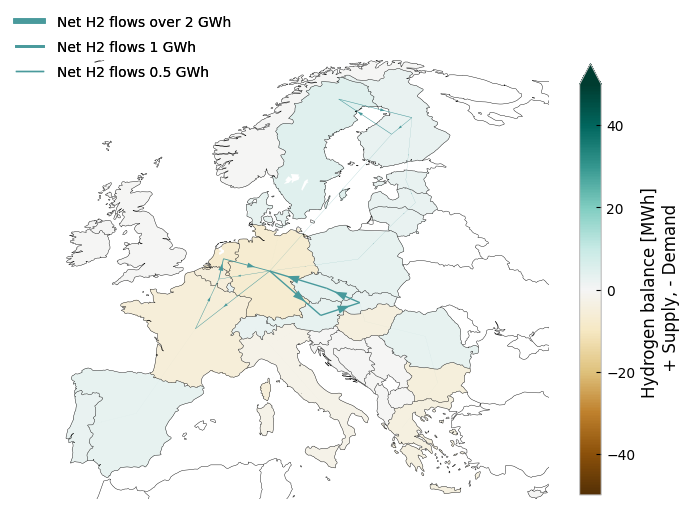

In [ ]:
h2_regions = bz.dissolve(by="country")
plot_net_H2_flows(n, h2_regions)